<a href="https://colab.research.google.com/github/elka97/MachineLearningInBusiness/blob/main/homework_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [65]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [67]:
DATA_PATH = "/gdrive/My Drive/Ml_In_Business/lection5_materials/"
training_dir = f"{DATA_PATH}/catboost_info/" 
DATA_PATH

'/gdrive/My Drive/Ml_In_Business/lection5_materials/'

In [68]:
df = pd.read_csv(f"{DATA_PATH}churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Посмотрим на распределение классов:

In [69]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

In [70]:
 class_balance = df['Exited'].value_counts().to_dict()
 class_balance

{0: 7963, 1: 2037}

In [71]:
df.drop(columns=["RowNumber","CustomerId","Surname"], inplace=True)

In [72]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [73]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [74]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Exited']), df['Exited'], random_state=0)

In [75]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 10), (2500, 10), (7500,), (2500,))

Зададим списки признаков

In [76]:
numeric_features = ['CreditScore', 'Balance', 'EstimatedSalary', 'Age']
cat_features = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']

In [77]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
      # ('scaler', StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
      ('cat', cat_pipe, cat_features),
      ('num', num_pipe, numeric_features)    
  ],
remainder="drop")

# **1. бустинг**

In [78]:
catboost_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(iterations=100, thread_count=8, random_state=42, silent=True, train_dir=training_dir, eval_metric="F1"))
])
catboost_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Geography', 'Gender',
                                                   'Tenure', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts']),
                                                 ('num'

In [82]:
#наши прогнозы для тестовой выборки
catboost_preds = catboost_pipe.predict_proba(X_test)[:, 1]
catboost_preds[:10]

array([0.44265383, 0.31757789, 0.13182143, 0.04039639, 0.01929036,
       0.8166045 , 0.0248744 , 0.20280872, 0.1552481 , 0.92590222])

# **2. логистическая регрессия**

In [80]:
logreg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, class_weight=class_balance))
])
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Geography', 'Gender',
                                                   'Tenure', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts']),
                                                 ('num'

In [83]:
#наши прогнозы для тестовой выборки
logreg_preds = logreg_pipe.predict_proba(X_test)[:, 1]
logreg_preds[:10]

array([0.09234207, 0.16839192, 0.05366608, 0.04802668, 0.01235113,
       0.08398849, 0.00597666, 0.00527709, 0.16729206, 0.16756615])

# Метрики

In [84]:
def get_metrics(probs):
    _precision, _recall, _thresholds = precision_recall_curve(y_test, probs)

    _fscore = (2 * _precision * _recall) / (_precision + _recall)
    # locate the index of the largest f score
    _ix = np.argmax(_fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (_thresholds[_ix], 
                                                                            _fscore[_ix],
                                                                            _precision[_ix],
                                                                            _recall[_ix],
                                                                            roc_auc_score(y_test, probs)))
    return _thresholds[_ix]

In [85]:
results = pd.DataFrame({'y_true': y_test,
              'CB': catboost_preds,
              'LR': logreg_preds})
results['AVG_cb_lr'] = results[['CB', 'LR']].mean(axis=1)
results

,y_true,CB,LR,AVG_cb_lr
9394,0,0.442654,0.092342,0.267498
898,1,0.317578,0.168392,0.242985
2398,0,0.131821,0.053666,0.092744
5906,0,0.040396,0.048027,0.044212
2343,0,0.019290,0.012351,0.015821
...,...,...,...,...
8764,0,0.322303,0.026960,0.174631
4359,0,0.645311,0.404190,0.524750
2041,0,0.159702,0.117048,0.138375
1108,0,0.128328,0.031098,0.079713


In [86]:
lr_threshold = get_metrics(results['LR'])
cb_threshold = get_metrics(results['CB'])

Best Threshold=0.109333, F-Score=0.584, Precision=0.540, Recall=0.637, Roc-AUC=0.837
Best Threshold=0.359048, F-Score=0.652, Precision=0.643, Recall=0.662, Roc-AUC=0.880


Confusion matrix, without normalization
[[1804  187]
 [ 173  336]]


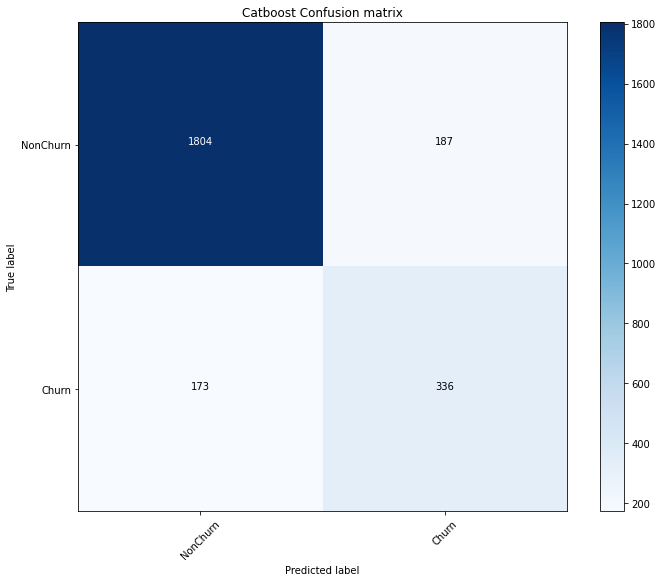

In [87]:
catboost_cnf_matrix = confusion_matrix(y_test, catboost_preds > cb_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(catboost_cnf_matrix, classes=['NonChurn', 'Churn'], title='Catboost Confusion matrix')
plt.show()

Confusion matrix, without normalization
[[1715  276]
 [ 186  323]]


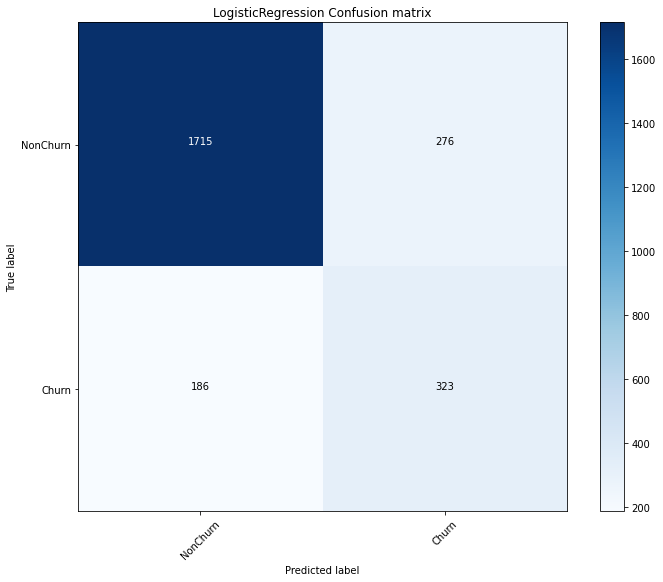

In [88]:
logreg_cnf_matrix = confusion_matrix(y_test, logreg_preds > lr_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(logreg_cnf_matrix, classes=['NonChurn', 'Churn'], title='LogisticRegression Confusion matrix')
plt.show()

**Best model:
Catboost F-Score=0.652, Precision=0.643, Recall=0.662**

# Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного).

In [90]:
tn, fp, fn, tp = catboost_cnf_matrix.ravel().astype(np.int)
tn, fp, fn, tp

(1804, 187, 173, 336)

In [91]:
retention_cost = 1
retention_revenue = 2

revenue = tp*(retention_revenue - retention_cost) - fp*(retention_revenue - retention_cost)
revenue

149